# Trabajo Práctico 2: Detectando lugares del mundo

In [33]:
# imports de libs que usamos para leer y procesar datos en masa
import os

import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning: separar conjuntos de datos, evaluar exactitud, etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# libs que usamos para construir y entrenar redes neuronales
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization

#libs para operaciones de manejo de archivos y directorios
import shutil

#libs para realizar preprocesamiento de imágenes en proyectos de deep learning
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tensorflow.keras.optimizers import Adam

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# Análisis Exploratorio del Conjunto de Datos

## 1. Volumetría de los Datos

Para entender la distribución de las imágenes en nuestro conjunto de datos, contamos el número de imágenes en cada categoría. A continuación, se muestra el número de imágenes por categoría:

- **buildings**: 2,191 imágenes
- **forest**: 2,271 imágenes
- **glacier**: 2,404 imágenes
- **mountain**: 2,512 imágenes
- **sea**: 2,274 imágenes
- **street**: 2,382 imágenes

En total, el conjunto de datos consta de **14,034 imágenes**, lo cual proporciona una base sólida para entrenar un modelo de aprendizaje profundo.

### Observaciones sobre la Volumetría:
- Las categorías están razonablemente equilibradas, con una diferencia máxima de aproximadamente 300 imágenes entre la categoría más pequeña (buildings) y la más grande (mountain).
- Este balance es beneficioso para el entrenamiento del modelo, ya que ayuda a prevenir sesgos significativos hacia categorías con más ejemplos.


Cantidad de imágenes por categoría:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382

Cantidad total de imágenes: 14034


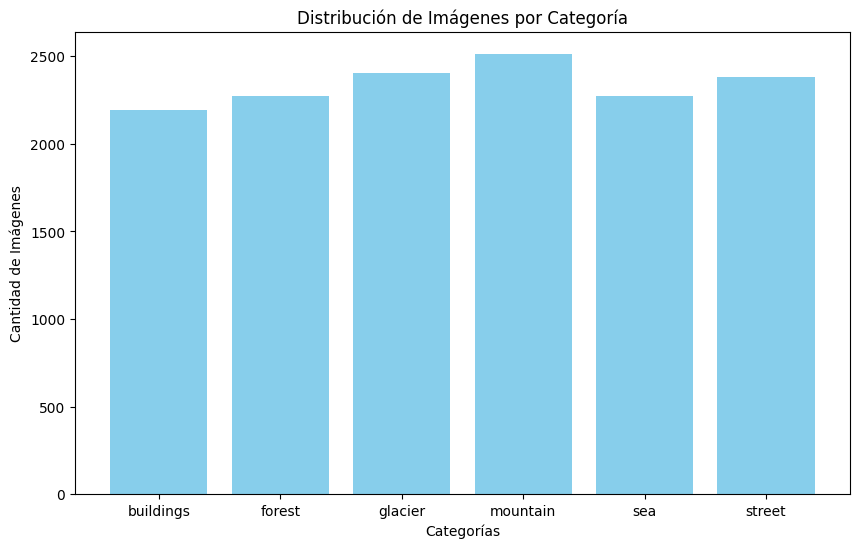

In [2]:
# definimos la ruta al directorio de datos
DATA_DIR = './train'  # reemplazamos con la ruta correcta

# categorías de las imágenes
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

counts = {}

for category in categories:
    category_path = os.path.join(DATA_DIR, category)
    image_files = [file for file in os.listdir(category_path)]
    counts[category] = len(image_files)

total_images = sum(counts.values())

print("Cantidad de imágenes por categoría:")
for category, count in counts.items():
    print(f"{category}: {count}")
print(f"\nCantidad total de imágenes: {total_images}")

# graficamos la distribución de imágenes por categoría
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categorías')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de Imágenes por Categoría')
plt.show()


## 2. Estructura y Tipo de las Imágenes

Las imágenes en el conjunto de datos son de tipo **RGB (color)** y ya están redimensionadas a un tamaño uniforme de **150x150 píxeles**. Esto es ideal para garantizar la consistencia al alimentar las imágenes a una red neuronal durante el entrenamiento.


In [3]:
# mostramos algunas imágenes de cada categoría
for category in categories:
    category_path = os.path.join(DATA_DIR, category)
    image_files = os.listdir(category_path)
    
    img_path = os.path.join(category_path, image_files[0])
    img = load_img(img_path)
    img_array = img_to_array(img)
    
    # información de la imagen
    print(f"Categoría: {category}")
    print(f"Dimensiones de la imagen: {img.size}")
    print(f"Número de canales: {img_array.shape[2]}")  # 3 para imágenes RGB
    print("-" * 40)


Categoría: buildings
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------
Categoría: forest
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------
Categoría: glacier
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------
Categoría: mountain
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------
Categoría: sea
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------
Categoría: street
Dimensiones de la imagen: (150, 150)
Número de canales: 3
----------------------------------------


# Modelado


# División del Conjunto de Datos

Para preparar el conjunto de datos para el entrenamiento y la validación, realizamos una división en la que el 80% de las imágenes se usaron para entrenamiento y el 20% restante para validación. La distribución resultante de las imágenes por categoría es la siguiente:

- **buildings**: 1,752 imágenes para entrenamiento, 439 imágenes para validación.
- **forest**: 1,816 imágenes para entrenamiento, 455 imágenes para validación.
- **glacier**: 1,923 imágenes para entrenamiento, 481 imágenes para validación.
- **mountain**: 2,009 imágenes para entrenamiento, 503 imágenes para validación.
- **sea**: 1,819 imágenes para entrenamiento, 455 imágenes para validación.
- **street**: 1,905 imágenes para entrenamiento, 477 imágenes para validación.

Esta distribución asegura que tengamos suficientes datos para entrenar el modelo mientras mantenemos un conjunto de validación adecuado para evaluar su rendimiento.


In [4]:
# creamos conjunto de train y validation
def create_train_validation_split(DATA_DIR, train_dir, validation_dir, categories, split_size=0.8):
    for category in categories:
        # Directorio de origen
        category_source = os.path.join(DATA_DIR, category)
        # Directorios de destino
        category_train = os.path.join(train_dir, category)
        category_validation = os.path.join(validation_dir, category)
        
        os.makedirs(category_train, exist_ok=True)
        os.makedirs(category_validation, exist_ok=True)
        
        images = [f for f in os.listdir(category_source) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
        train_images, validation_images = train_test_split(images, train_size=split_size, random_state=42)
        
        for img in train_images:
            src = os.path.join(category_source, img)
            dst = os.path.join(category_train, img)
            shutil.copyfile(src, dst)
        
        for img in validation_images:
            src = os.path.join(category_source, img)
            dst = os.path.join(category_validation, img)
            shutil.copyfile(src, dst)
        
        print(f"Categoría '{category}': {len(train_images)} imágenes para entrenamiento, {len(validation_images)} imágenes para validación.")

# directorios
train_dir = os.path.join(DATA_DIR, 'train')
validation_dir = os.path.join(DATA_DIR, 'validation')

# división
create_train_validation_split(DATA_DIR, train_dir, validation_dir, categories, split_size=0.8)


Categoría 'buildings': 1752 imágenes para entrenamiento, 439 imágenes para validación.
Categoría 'forest': 1816 imágenes para entrenamiento, 455 imágenes para validación.
Categoría 'glacier': 1923 imágenes para entrenamiento, 481 imágenes para validación.
Categoría 'mountain': 2009 imágenes para entrenamiento, 503 imágenes para validación.
Categoría 'sea': 1819 imágenes para entrenamiento, 455 imágenes para validación.
Categoría 'street': 1905 imágenes para entrenamiento, 477 imágenes para validación.


# Preparación y Mejora de los Datos

## Calidad y Diversidad de las Imágenes
La calidad y diversidad de las imágenes dentro de cada categoría juegan un papel fundamental en el rendimiento del modelo. Es importante evaluar si hay suficiente variación visual para que el modelo pueda aprender de manera efectiva. Si las imágenes de una categoría son demasiado homogéneas o de baja calidad, el modelo podría tener dificultades para generalizar correctamente.

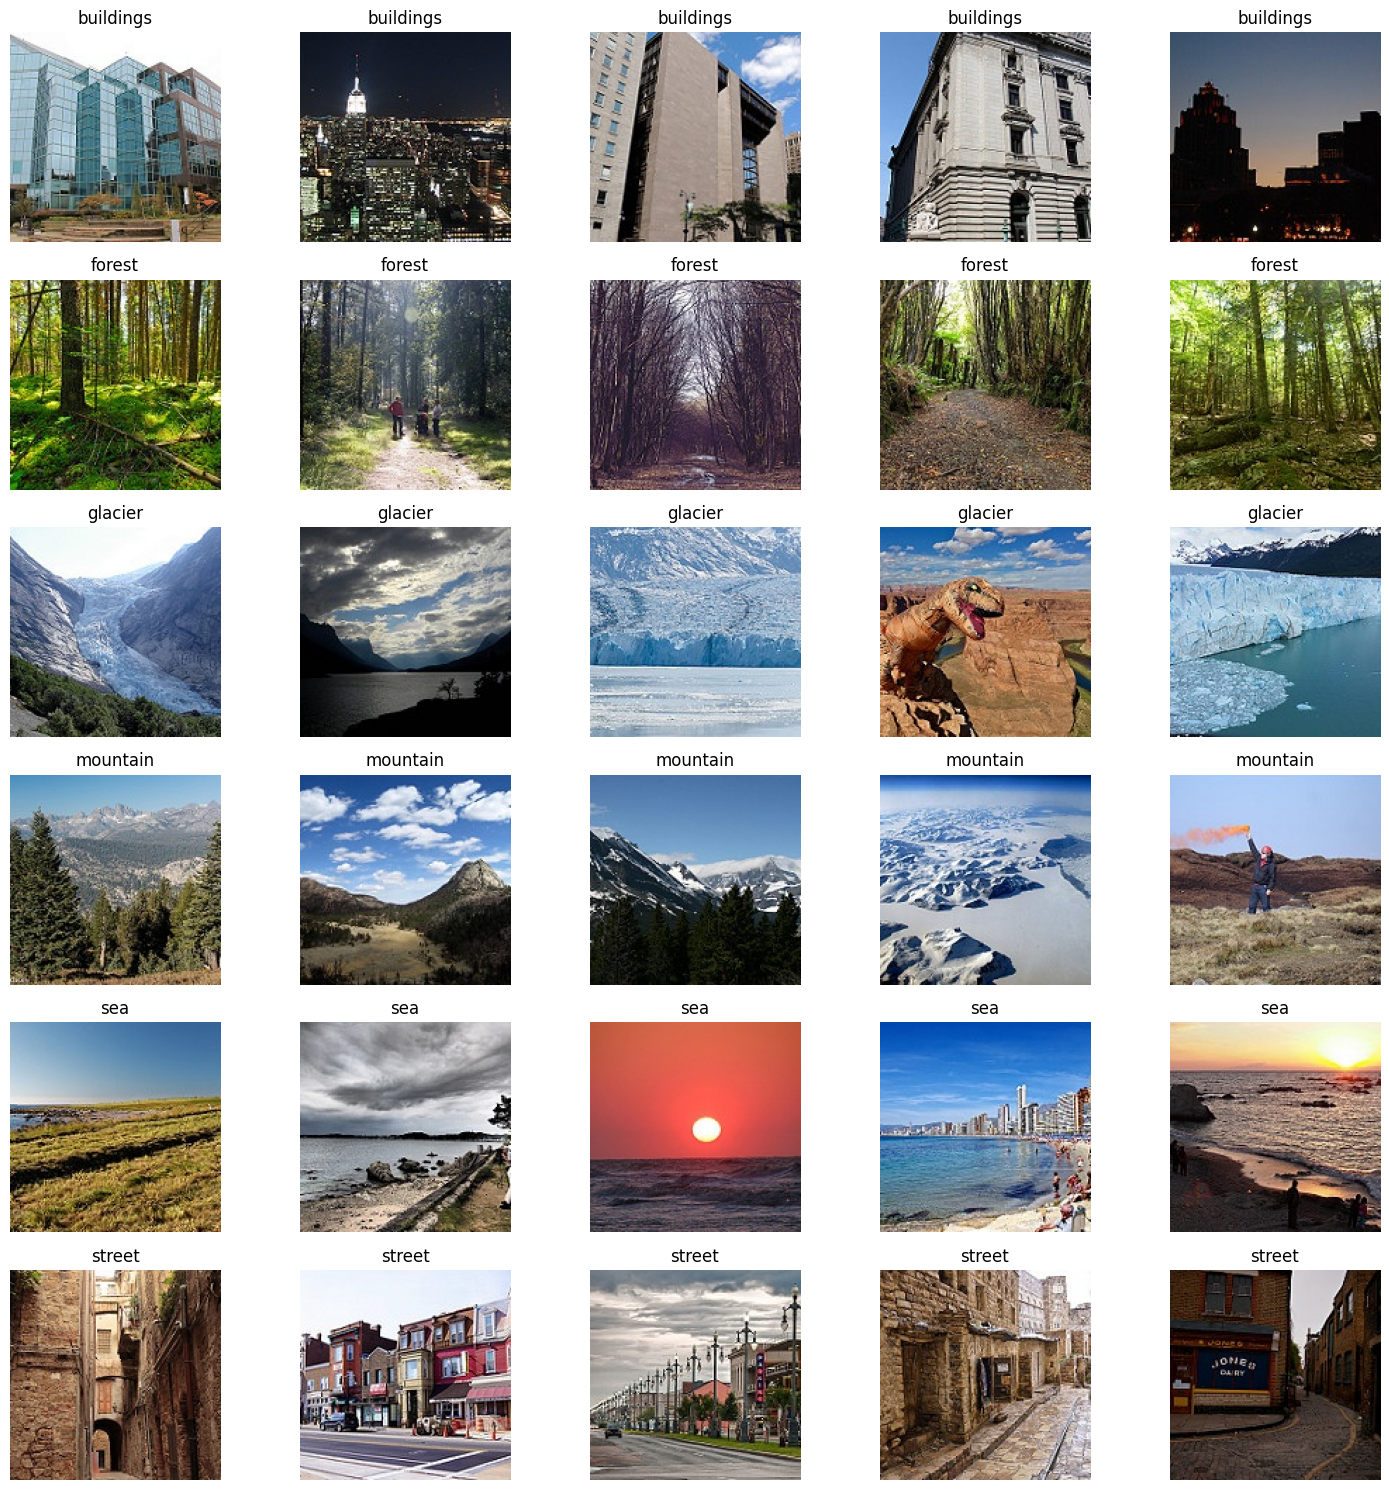

In [30]:
import random

img_size = (150, 150)

train_images_dir = "./train/"

class_dirs = [d for d in os.listdir(train_images_dir) if os.path.isdir(os.path.join(train_images_dir, d))]

# seleccionamos 5 imágenes al azar por clase
selected_images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_images_dir, class_dir)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]
    selected_images.extend(random.sample(class_images, min(5, len(class_images))))

test_images = []
predicted_classes = []
for img_path in selected_images:
    img = load_img(img_path, target_size=img_size)  
    img_array = img_to_array(img) 
    img_array = img_array / 255.0  
    test_images.append(img_array)
    predicted_classes.append(os.path.basename(os.path.dirname(img_path)))  # Usar la clase original como título

test_images = np.array(test_images)

# mostramos las imágenes y sus clases originales
plt.figure(figsize=(15, 15))
for i in range(len(test_images)):
    plt.subplot(6, 5, i + 1) 
    plt.imshow(test_images[i])
    plt.title(predicted_classes[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

La calidad y variación de las imágenes dentro de cada categoría parecen adecuadas, mostrando diversidad en términos de escenarios, iluminación y perspectivas, lo que es crucial para garantizar un aprendizaje robusto y generalizable del modelo.
Basándonos en la diversidad visual existente en las imágenes, planteamos la hipótesis de que aplicar técnicas de aumentación no mejorará significativamente los resultados, ya que el conjunto de datos ya proporciona suficiente variación para un entrenamiento efectivo.

## Aumentación de Datos
Para mejorar la capacidad de generalización del modelo y prevenir el sobreajuste, se pueden aplicar técnicas de aumentación de datos. Estas técnicas incluyen rotaciones, desplazamientos horizontales y verticales, zoom aleatorio y volteo de las imágenes. La aumentación ayuda a simular la diversidad del mundo real y a hacer que el modelo sea más robusto ante variaciones en las imágenes.

In [6]:
# configuramos un generador de datos para entrenamiento básico
train_datagen = ImageDataGenerator(rescale=1./255)

# configuramos el generador de datos para entrenamiento con aumentación
train_datagen_1 = ImageDataGenerator(
    rescale=1./255,                # normalizacion
    rotation_range=40,             
    zoom_range=0.2,                
    horizontal_flip=True,          
    fill_mode='nearest'            
)

# configuramos el generador de datos para entrenamiento con aumentación plus
train_datagen_2 = ImageDataGenerator(
    rescale=1./255,                
    rotation_range=10,                         
    zoom_range=0.1,                
    width_shift_range=0.1,         
    height_shift_range=0.2,        
    fill_mode='nearest'            
)

# creamos el generador de datos para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),         
    batch_size=32,
    class_mode='categorical'        
)

train_generator_1 = train_datagen_1.flow_from_directory(
    train_dir,
    target_size=(150, 150),         
    batch_size=32,
    class_mode='categorical'
)

train_generator_2 = train_datagen_2.flow_from_directory(
    train_dir,
    target_size=(150, 150),         
    batch_size=32,
    class_mode='categorical'
)

# generador de datos para validación
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 11224 images belonging to 6 classes.
Found 11224 images belonging to 6 classes.
Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.


Nota: Para nuestros modelos, las imágenes se organizaron en directorios según su clase, y utilizamos `flow_from_directory` de **Keras** para cargar y preprocesar los datos de manera eficiente.

In [7]:
print(train_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [7]:
# Función para mostrar la precisión a lo largo de las épocas
def MostrarHistorial(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation_accuracy')
    plt.title('Precisión a lo largo de las Épocas')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(loc='upper left')
    plt.show()

## Evaluación de Modelos

En este trabajo, utilizamos dos tipos de redes neuronales: perceptrones multicapa (MLP) y redes convolucionales (CNN). Ambos modelos fueron ajustados con diferentes configuraciones, variando parámetros como el número de capas, neuronas, filtros, tamaño del kernel, épocas, batch size y dropout, con el objetivo de comparar su rendimiento y desempeño.


##  MLP simple

## Detalles Generales de las Capas Utilizadas en MLP

### Tipos de Capas

1. **Capas Densas (Fully Connected)**:
   - Son la base de los modelos MLP. Cada neurona está conectada a todas las neuronas de la capa anterior.
   - **Rango de Neuronas**: Desde 64 hasta 512 por capa.

2. **Capas de Regularización**:
   - **Dropout**: Utilizado para reducir el sobreajuste al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento.
   - **Rango de Dropout**: Entre 0.2 y 0.5, dependiendo de la complejidad del modelo.

3. **Funciones de Activación**:
   - **ReLU**: La activación estándar en todos los modelos MLP, introduciendo no linealidad y mejorando la capacidad de aprendizaje.

### Rango de Parámetros Explorados

- **Número de Capas Densas**: Probamos configuraciones con entre 2 y 4 capas densas.
- **Neuronas por Capa**: Entre 64 y 512, dependiendo del modelo.
- **Dropout**: Se usaron tasas de Dropout entre 20% y 50%.

### Resultados Generales

- Los modelos más simples (2 capas densas) fueron menos propensos al sobreajuste pero con menor precisión predictiva.
- Los modelos más complejos (4 capas densas) mostraron mejores resultados en accuracy, especialmente cuando se combinaban con tasas de Dropout más altas.

In [34]:
# Modelo MLP 1
model_mlp_1 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  
    Dense(64, activation='relu'),        
    Dropout(0.3),                        
    Dense(len(categories), activation='softmax') 
])

model_mlp_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mlp_1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │       4,320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,320,454 (16.48 MB)

 Trainable params: 4,320,454 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Modelo MLP 2
model_mlp_2 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  
    Dense(128, activation='relu'),       
    Dropout(0.4),                        
    Dense(64, activation='relu'),        
    Dropout(0.3),                       
    Dense(len(categories), activation='softmax') 
])

model_mlp_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mlp_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,648,774 (32.99 MB)

 Trainable params: 8,648,774 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# entreno primer modelo
history_mlp_1 = model_mlp_1.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator
)

# entreno segundo modelo
history_mlp_2 = model_mlp_2.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator
)

Epoch 1/10


C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.1781 - loss: 3.6037 - val_accuracy: 0.1790 - val_loss: 1.7910
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.1824 - loss: 1.7908 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.1790 - loss: 1.7906 - val_accuracy: 0.1790 - val_loss: 1.7911
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.1717 - loss: 1.7921 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.1857 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.1743 - loss: 1.7917 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.1779 - loss: 1.7907 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.1811 - loss: 1.7906 - val_accurac

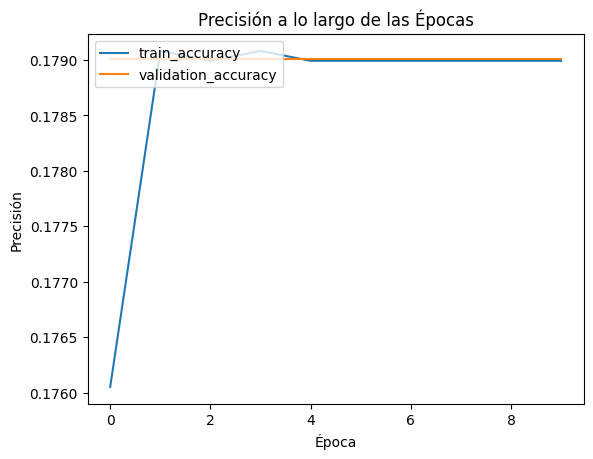

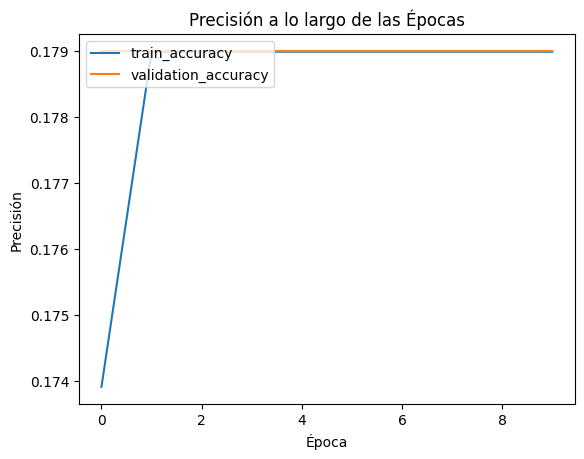

In [12]:
MostrarHistorial(history_mlp_1)
MostrarHistorial(history_mlp_2)

El modelo muestra una precisión extremadamente baja y estancada tanto en el conjunto de entrenamiento como en el de validación (~17%), lo que indica que no está aprendiendo adecuadamente y necesita ajustes significativos en la arquitectura o el preprocesamiento de datos.

In [14]:
# Modelo MLP optimizado
model_mlp_3 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  

    Dense(256, activation='relu'),       
    BatchNormalization(),                
    Dropout(0.5),                       

    Dense(128, activation='relu'),      
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),        
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(categories), activation='softmax') 
])

model_mlp_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mlp_3.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      17,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,323,590 (66.08 MB)

 Trainable params: 17,322,694 (66.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
# entreno del tercer  modelo
history_mlp_3 = model_mlp_3.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 218ms/step - accuracy: 0.3187 - loss: 1.9315 - val_accuracy: 0.4705 - val_loss: 1.3763
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 252ms/step - accuracy: 0.4483 - loss: 1.4411 - val_accuracy: 0.5167 - val_loss: 1.2877
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 276ms/step - accuracy: 0.4780 - loss: 1.3621 - val_accuracy: 0.4566 - val_loss: 1.4386
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 280ms/step - accuracy: 0.4915 - loss: 1.2921 - val_accuracy: 0.5431 - val_loss: 1.2232
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 281ms/step - accuracy: 0.4995 - loss: 1.2880 - val_accuracy: 0.4897 - val_loss: 1.3326
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.5145 - loss: 1.2750 - val_accuracy: 0.5125 - val_loss: 1.2643
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.5130 - loss: 1.2693 - val_accuracy: 0.4972 - val_loss: 1.3102
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.5126 - loss: 1

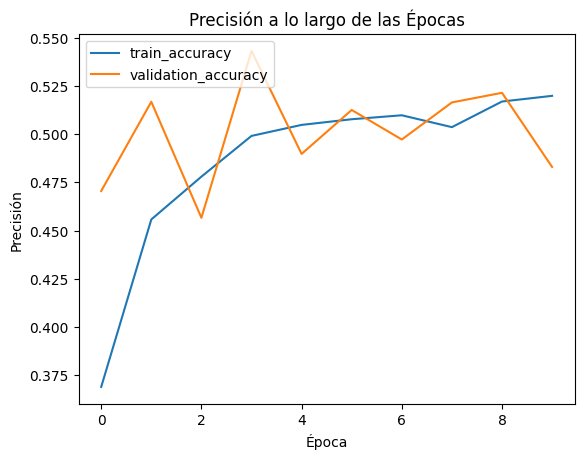

In [16]:
MostrarHistorial(history_mlp_3)

Con el último modelo implementado, observamos una mejora moderada en la precisión a lo largo de las épocas, alcanzando un valor de entrenamiento cercano al 52%. Sin embargo, se aprecia cierta variabilidad en la precisión de validación, lo que podría indicar problemas de generalización o sobreajuste en ciertas etapas.

El gráfico muestra que, aunque hay un progreso en la precisión de entrenamiento, la precisión de validación presenta fluctuaciones significativas. Esto sugiere que los ajustes realizados en la arquitectura y los hiperparámetros tuvieron un impacto, pero aún existe margen para mejorar la estabilidad y el rendimiento del modelo.

Como siguiente paso, vamos a ajustar el learning rate para intentar mejorar la convergencia y la estabilidad de la precisión de validación.

In [17]:
optimizer = Adam(learning_rate=0.0001)

# Modelo MLP optimizado
model_mlp_optimized = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # aplana

    Dense(256, activation='relu'),       # capa oculta con 256 neuronas
    BatchNormalization(),                # normalización por lotes
    Dropout(0.5),                        # dropout del 50%

    Dense(128, activation='relu'),       # capa oculta con 128 neuronas
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),        # capa oculta con 64 neuronas
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(categories), activation='softmax')  # salida con Softmax
])

# compila el modelo con el optimizador personalizado
model_mlp_optimized.compile(
    optimizer=optimizer,  # optimizador con learning rate ajustado
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mlp_optimized.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │      17,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,323,590 (66.08 MB)

 Trainable params: 17,322,694 (66.08 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 246ms/step - accuracy: 0.4372 - loss: 1.5416 - val_accuracy: 0.5164 - val_loss: 1.2646
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 244ms/step - accuracy: 0.4221 - loss: 1.5313 - val_accuracy: 0.4669 - val_loss: 1.3502
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 245ms/step - accuracy: 0.4197 - loss: 1.5409 - val_accuracy: 0.5278 - val_loss: 1.2524
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 261ms/step - accuracy: 0.4335 - loss: 1.5150 - val_accuracy: 0.5381 - val_loss: 1.2300
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 274ms/step - accuracy: 0.4312 - loss: 1.4851 - val_accuracy: 0.5459 - val_loss: 1.2147
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 282ms/step - accuracy: 0.4431 - loss: 1.4629 - val_accuracy: 0.5342 - val_loss: 1.2150
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 282ms/step - accuracy: 0.4419 - loss: 1.4546 - val_accuracy: 0.5338 - val_loss: 1.2346
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 274ms/step - accuracy: 0.4491 - loss:

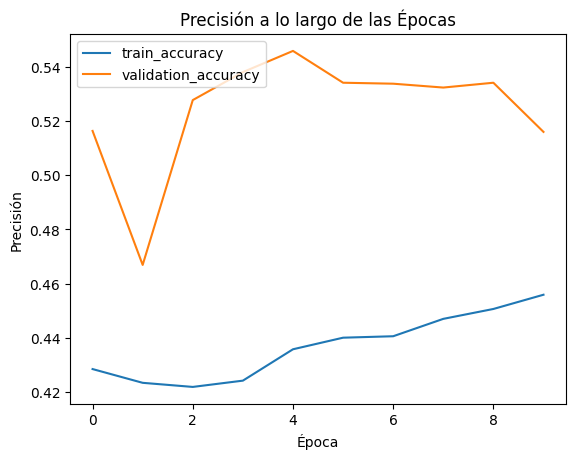

In [19]:
# el tercer  modelo
history_mlp_optimized = model_mlp_optimized.fit(
    train_generator_2,
    epochs=10,  
    validation_data=validation_generator
)
MostrarHistorial(history_mlp_optimized)

Probamos ajustar el learning rate, esperando mejorar la convergencia y estabilizar la precisión de validación. Sin embargo, estos cambios no resultaron en mejoras significativas. Asimismo, aplicamos técnicas de aumentación de datos para enriquecer el conjunto de entrenamiento, pero tampoco se observó un impacto positivo en los resultados.

Estos resultados sugieren que el modelo aún no está capturando adecuadamente los patrones presentes en los datos, lo que plantea la necesidad de explorar arquitecturas más complejas o ajustar otros hiperparámetros. Más adelante, documentaremos en detalle los experimentos realizados y el impacto de cada ajuste.

## Convoluciones

## Detalles Generales de las Capas Utilizadas en CNN

### Tipos de Capas

1. **Capas Convolucionales**:
   - Utilizadas para extraer características espaciales de las imágenes.
   - **Rango de Filtros**: Desde 8 hasta 256 filtros por capa.
   - **Tamaño del Kernel**: Probamos tamaños de (3,3) y (5,5).
   - **Funciones de Activación**: Principalmente `ReLU`, por su eficiencia en modelos convolucionales.

2. **Capas de Pooling**:
   - **MaxPooling**: Redujo la dimensionalidad de las características después de cada capa convolucional.
   - **Tamaño del Pooling**: Generalmente (2,2) o (3,3).

3. **Capas de Regularización**:
   - **Dropout**: Implementado después de ciertas capas para prevenir el sobreajuste.
   - **Rango de Dropout**: Entre 0.2 y 0.5.
   - **Batch Normalization**: Ayudó a estabilizar y acelerar el entrenamiento en modelos más complejos.

4. **Capas Densas**:
   - Utilizadas al final para la clasificación.
   - **Neuronas**: Entre 64 y 256, dependiendo del modelo.
   - **Funciones de Activación**: `ReLU` en capas internas, `Softmax` en la capa de salida para clasificación multiclase.

### Resultados Generales

- Los modelos más simples (2 capas convolucionales) mostraron un rendimiento básico, adecuado para establecer una línea base.
- Los modelos más complejos (5 capas convolucionales) lograron mejores resultados en accuracy, pero fueron más propensos al sobreajuste.
- La combinación de **Batch Normalization** y **Dropout** mejoró significativamente la generalización.

In [35]:
model_conv_1 = Sequential([
    Convolution2D(8, (4, 4), activation='relu', input_shape=(150, 150, 3),),
    Convolution2D(8, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.2),
    Flatten(),
    
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='tanh'),
    Dropout(0.2),

    Dense(len(categories), activation='softmax'),
])

model_conv_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.4366 - loss: 1.4040 - val_accuracy: 0.6826 - val_loss: 0.9061
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.6387 - loss: 0.9768 - val_accuracy: 0.7164 - val_loss: 0.7994
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6826 - loss: 0.8698 - val_accuracy: 0.7238 - val_loss: 0.7889
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.7252 - loss: 0.7787 - val_accuracy: 0.7249 - val_loss: 0.7462
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.7541 - loss: 0.6965 - val_accuracy: 0.7388 - val_loss: 0.7110
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7891 - loss: 0.6276 - val_accuracy: 0.7605 - val_loss: 0.6735
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8198 - loss: 0.5575 - val_accuracy: 0.7683 - val_loss: 0.6687
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8327 - loss: 0.5096 - 

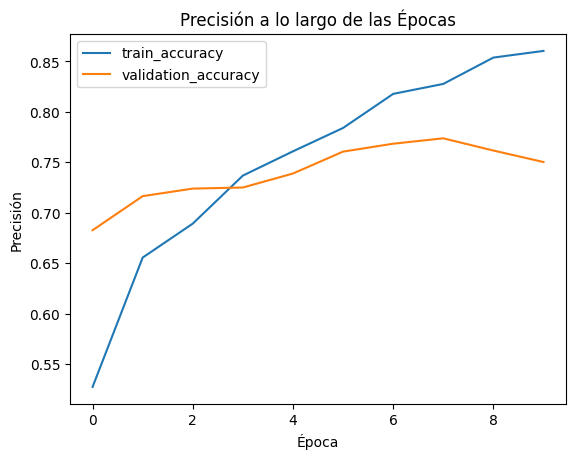

In [17]:
# el primer modelo
history_conv_1 = model_conv_1.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator
)

MostrarHistorial(history_conv_1)

El modelo convolucional muestra un rendimiento inicial prometedor con una precisión de entrenamiento que aumenta constantemente a lo largo de las épocas, alcanzando un 86% en la última época. Sin embargo, la precisión de validación es considerablemente más baja y parece estancarse alrededor del 75%, lo que sugiere que el modelo podría estar empezando a sobreajustarse a los datos de entrenamiento.

Próximos Pasos
- Considerar agregar más regularización, como aumentar la tasa de Dropout o utilizar técnicas de aumentación de datos más agresivas.
- Probar con una arquitectura de modelo más compleja o ajustada para mejorar la capacidad de generalización.

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 147ms/step - accuracy: 0.3867 - loss: 1.4679 - val_accuracy: 0.6053 - val_loss: 1.0515
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.5644 - loss: 1.1386 - val_accuracy: 0.6299 - val_loss: 1.0199
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.5889 - loss: 1.0811 - val_accuracy: 0.6808 - val_loss: 0.8973
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6126 - loss: 1.0377 - val_accuracy: 0.6352 - val_loss: 0.9504
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.6156 - loss: 1.0358 - val_accuracy: 0.6028 - val_loss: 1.0286
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6213 - loss: 1.0046 - val_accuracy: 0.6715 - val_loss: 0.9066
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6328 - loss: 0.9780 - val_accuracy: 0.6947 - val_loss: 0.8397
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6367 - loss: 0

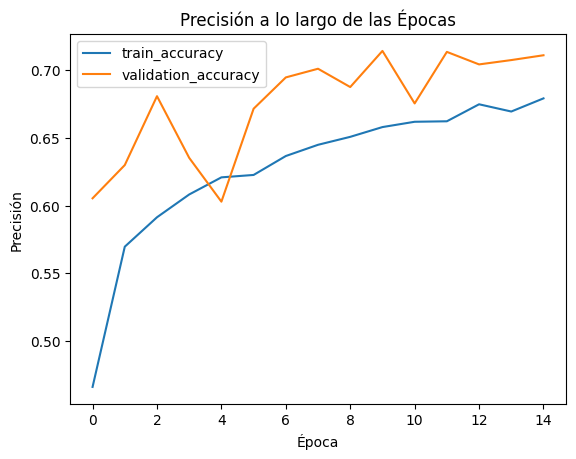

In [22]:
# entrenamiento primer modelo pero con aumentación
history_conv_1 = model_conv_1.fit(
    train_generator_1,
    epochs=15,  
    validation_data=validation_generator
)

MostrarHistorial(history_conv_1)

Entrenamos el modelo con aumentación de datos y mas épocas. La precisión de validación se estabiliza con fluctuaciones, lo que sugiere que continuar entrenando más épocas probablemente no mejorará el rendimiento y podría llevar al sobreajuste.

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.7618 - loss: 0.6848 - val_accuracy: 0.7694 - val_loss: 0.6955
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7506 - loss: 0.7084 - val_accuracy: 0.7972 - val_loss: 0.5837
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7632 - loss: 0.6834 - val_accuracy: 0.8000 - val_loss: 0.6005
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7548 - loss: 0.6868 - val_accuracy: 0.7829 - val_loss: 0.6428
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.7627 - loss: 0.6821 - val_accuracy: 0.7868 - val_loss: 0.6338
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.7473 - loss: 0.7013 - val_accuracy: 0.7879 - val_loss: 0.6226
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7649 - loss: 0.6879 - val_accuracy: 0.8089 - val_loss: 0.5700
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.7656 - loss: 0

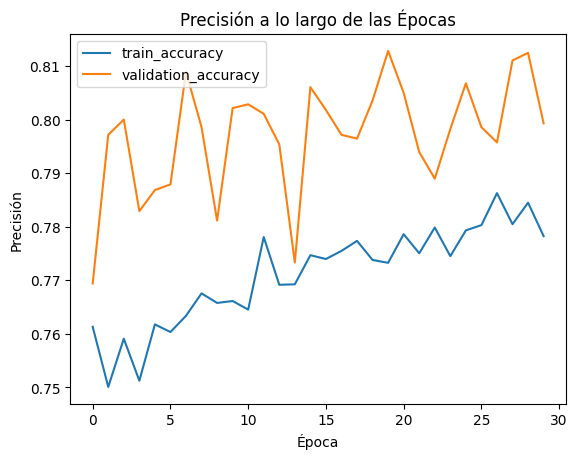

In [24]:
# entrenamiento primer modelo pero con aumentación
history_conv_1 = model_conv_1.fit(
    train_generator_2,
    epochs=30,  
    validation_data=validation_generator
)

MostrarHistorial(history_conv_1)

Observaciones tras aumentar el número de épocas al doble

Tras agregar más épocas, observamos que la **precisión de entrenamiento** sigue mejorando lentamente, alcanzando aproximadamente **0.78** en la última época. Sin embargo, la **precisión de validación** muestra fluctuaciones significativas, manteniéndose alrededor de **0.81** en su mejor momento, pero también decreciendo en algunas épocas finales.

- **Fluctuaciones en la validación**: Aunque el modelo alcanza un buen nivel de precisión en validación, la inestabilidad sugiere que el modelo no está generalizando de manera consistente.
- **Posible sobreajuste**: La diferencia entre la precisión de entrenamiento y validación, junto con la inestabilidad de esta última, podría indicar que el modelo está comenzando a ajustarse demasiado a los datos de entrenamiento.
- **Estancamiento en el aprendizaje**: Agregar más épocas no proporcionó una mejora sustancial en el rendimiento y, de hecho, podría estar perjudicando la estabilidad del modelo.

Al repetir el entrenamiento con el mismo modelo, notamos que el modelo parece "recordar" configuraciones previas, ya que los valores iniciales de precisión y pérdida son sorprendentemente altos. Esto sugiere que se guarda cierta **información en la memoria del entorno de ejecución**, lo que podría influir en los resultados iniciales de los nuevos entrenamientos.

## Buscando el mejor

In [10]:
model_the_best = Sequential([
    
    Convolution2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Convolution2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax'),
])

model_the_best.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

history_the_best = model_the_best.fit(
    train_generator_2,
    epochs=20,  
    validation_data=validation_generator
)
#Comentarios de referencia a la competición P10 0.86

C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.4344 - loss: 1.3771 - val_accuracy: 0.5925 - val_loss: 1.0337
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.6313 - loss: 0.9672 - val_accuracy: 0.7338 - val_loss: 0.7759
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.6896 - loss: 0.8456 - val_accuracy: 0.6701 - val_loss: 0.8775
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.7307 - loss: 0.7475 - val_accuracy: 0.7466 - val_loss: 0.7171
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.7519 - loss: 0.6926 - val_accuracy: 0.7306 - val_loss: 0.7768
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7641 - loss: 0.6632 - val_accuracy: 0.8114 - val_loss: 0.5396
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.7743 - loss: 0.6456 - val_accuracy: 0.8064 - val_loss: 0.5449
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.7905 - loss: 0.5886 - val

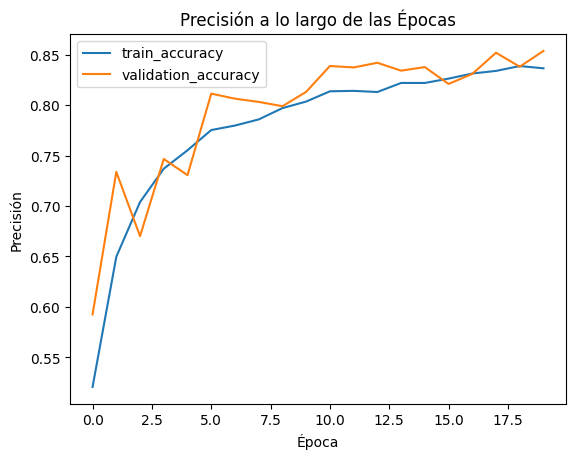

In [11]:
MostrarHistorial(history_the_best)

En este gráfico observamos que tanto la **precisión de entrenamiento** como la **precisión de validación** muestran una tendencia ascendente y convergen alrededor de **0.85** en las últimas épocas. La validación, aunque fluctúa al inicio, se estabiliza y sigue de cerca a la precisión de entrenamiento, lo que indica que el modelo está generalizando mejor que en entrenamientos anteriores.

Aunque el modelo parece haber alcanzado un buen rendimiento, es posible que con ligeros ajustes en los hiperparámetros (como el learning rate) o técnicas adicionales, se pueda optimizar aún más.

C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.3941 - loss: 1.3939 - val_accuracy: 0.6125 - val_loss: 0.9652
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.5987 - loss: 1.0114 - val_accuracy: 0.6982 - val_loss: 0.8136
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.6645 - loss: 0.8869 - val_accuracy: 0.7249 - val_loss: 0.7540
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.7169 - loss: 0.7704 - val_accuracy: 0.7786 - val_loss: 0.6189
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.7401 - loss: 0.7203 - val_accuracy: 0.7616 - val_loss: 0.6572
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.7635 - loss: 0.6564 - val_accuracy: 0.7964 - val_loss: 0.5623
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.7699 - loss: 0.6371 - val_accuracy: 0.8046 - val_loss: 0.5398
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.7923 - loss: 0.6024 - val

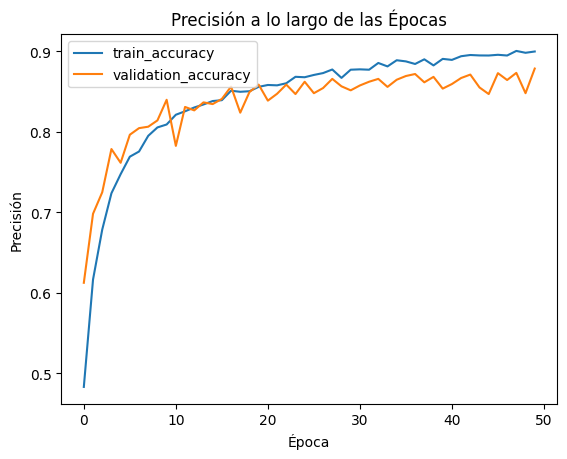

In [9]:
# agregamos una capa convolucional
model_the_best_10 = Sequential([
    # primera capa convolucional
    Convolution2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # segunda capa convolucional
    Convolution2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # tercera capa convolucional
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # cuarta capa convolucional
    Convolution2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # capas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax'),
])

model_the_best_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

history_the_best_10 = model_the_best_10.fit(
    train_generator_2,
    epochs=50,  
    validation_data=validation_generator
)

MostrarHistorial(history_the_best_10)

#comentarios de referencia para la competencia P8=30epocs=0.85
'''
Epoch 49/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.9038 - loss: 0.2559 - val_accuracy: 0.8480 - val_loss: 0.5101
Epoch 50/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - accuracy: 0.8961 - loss: 0.2934 - val_accuracy: 0.8786 - val_loss: 0.4385
p11=0.87
'''


En este gráfico observamos que tanto la **precisión de entrenamiento** como la **precisión de validación** muestran una tendencia ascendente, estabilizándose hacia las últimas épocas. La precisión de validación se mantiene cercana a **0.87**, mientras que la precisión de entrenamiento alcanza un máximo de **0.90**. La proximidad entre las curvas de entrenamiento y validación indica un buen nivel de generalización del modelo.

Aunque hay fluctuaciones menores en la precisión de validación, estas se mantienen controladas, lo que sugiere que el modelo ha encontrado un equilibrio adecuado.
Con 50 épocas, el modelo parece haber alcanzado su capacidad máxima con la configuración actual, y es poco probable que más épocas resulten en mejoras significativas.

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 273s 767ms/step - accuracy: 0.4592 - loss: 2.6657 - val_accuracy: 0.4708 - val_loss: 1.5865
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 282s 801ms/step - accuracy: 0.6075 - loss: 1.0783 - val_accuracy: 0.6779 - val_loss: 0.8535
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 286s 812ms/step - accuracy: 0.6645 - loss: 0.9119 - val_accuracy: 0.5306 - val_loss: 1.5765
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 285s 808ms/step - accuracy: 0.7071 - loss: 0.8232 - val_accuracy: 0.7416 - val_loss: 0.7051
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 288s 817ms/step - accuracy: 0.7216 - loss: 0.7805 - val_accuracy: 0.6680 - val_loss: 0.9698
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 305s 865ms/step - accuracy: 0.7449 - loss: 0.7350 - val_accuracy: 0.7210 - val_loss: 0.9363
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 296s 841ms/step - accuracy: 0.7570 - loss: 0.7018 - val_accuracy: 0.5206 - val_loss: 1.9513
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 286s 811ms/step - accuracy: 0.7728 -

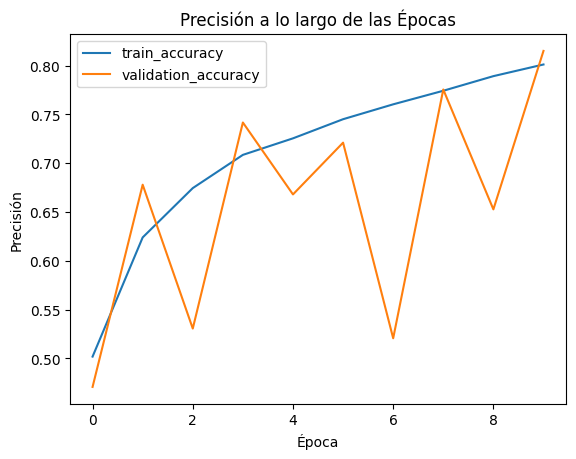

In [31]:
model_the_best_2 = Sequential([
    # primera capa convolucional con BatchNormalization
    Convolution2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # segunda capa convolucional con más filtros
    Convolution2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # tercera capa convolucional con más filtros
    Convolution2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # cuarta capa convolucional con más filtros
    Convolution2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # capas densas con Dropout
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax'),
])

model_the_best_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_the_best_2 = model_the_best_2.fit(
    train_generator_2,
    epochs=10, 
    validation_data=validation_generator
)

MostrarHistorial(history_the_best_2)

El modelo model_the_best_2 mostró un buen desempeño en el entrenamiento, alcanzando un 79.6% de precisión, pero la precisión de validación fluctuó alrededor del 70%, lo que indica que aunque la regularización aplicada (Batch Normalization y Dropout) ayudó a estabilizar el entrenamiento, aún se requieren ajustes en los hiperparámetros o más datos para mejorar la capacidad de generalización.

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.3255 - loss: 1.5170 - val_accuracy: 0.5851 - val_loss: 1.0400
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.5677 - loss: 1.0455 - val_accuracy: 0.6712 - val_loss: 0.8519
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.6290 - loss: 0.9253 - val_accuracy: 0.7053 - val_loss: 0.8126
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.6901 - loss: 0.8221 - val_accuracy: 0.7317 - val_loss: 0.7345
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 214ms/step - accuracy: 0.7313 - loss: 0.7309 - val_accuracy: 0.7512 - val_loss: 0.6614
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 201ms/step - accuracy: 0.7449 - loss: 0.6963 - val_accuracy: 0.7669 - val_loss: 0.6204
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.7644 - loss: 0.6523 - val_accuracy: 0.7819 - val_loss: 0.6045
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.7794 - loss: 0

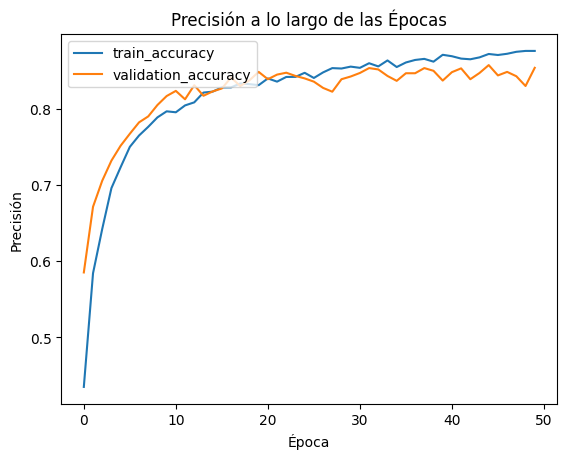

'\n#P50.8\nEpoch 13/14\n351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 201ms/step - accuracy: 0.8060 - loss: 0.5389 - val_accuracy: 0.8121 - val_loss: 0.5221\nEpoch 14/14\n351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - accuracy: 0.8095 - loss: 0.5160 - val_accuracy: 0.8157 - val_loss: 0.5179\n#P6=0.81\n\nEpoch 18/20\n351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.8282 - loss: 0.4817 - val_accuracy: 0.8171 - val_loss: 0.5343\nEpoch 19/20\n351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.8284 - loss: 0.4736 - val_accuracy: 0.7979 - val_loss: 0.5495\nEpoch 20/20\n351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.8291 - loss: 0.4732 - val_accuracy: 0.8335 - val_loss: 0.4613\n#p7\n'

In [29]:
model_the_best_3111945 = Sequential([
    # primera capa convolucional
    Convolution2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # segunda capa convolucional
    Convolution2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    # tercera capa convolucional
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # cuarta capa convolucional
    Convolution2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    # cuarta capa convolucional
    Convolution2D(248, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # capas densas
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax'),
])

model_the_best_3111945.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

history_the_best_311194 = model_the_best_3111945.fit(
    train_generator_2,
    epochs=50,  
    validation_data=validation_generator
)

MostrarHistorial(history_the_best_311194)
#comentarios para referencia de la competencia 
'''
#P50.8
Epoch 13/14
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 201ms/step - accuracy: 0.8060 - loss: 0.5389 - val_accuracy: 0.8121 - val_loss: 0.5221
Epoch 14/14
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - accuracy: 0.8095 - loss: 0.5160 - val_accuracy: 0.8157 - val_loss: 0.5179
#P6=0.81

Epoch 18/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.8282 - loss: 0.4817 - val_accuracy: 0.8171 - val_loss: 0.5343
Epoch 19/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.8284 - loss: 0.4736 - val_accuracy: 0.7979 - val_loss: 0.5495
Epoch 20/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.8291 - loss: 0.4732 - val_accuracy: 0.8335 - val_loss: 0.4613
#p7
'''

El modelo mostró un buen desempeño, alcanzando una precisión de entrenamiento del 87.9% y una precisión de validación del 85.3% tras 50 épocas. La pérdida en validación se mantuvo baja (0.4231), lo que indica una buena capacidad de generalización. La curva de precisión muestra un comportamiento consistente, con la validación manteniéndose cerca del entrenamiento, lo que sugiere que el modelo no presenta signos evidentes de sobreajuste. Este resultado valida que la arquitectura elegida y las técnicas de regularización aplicadas fueron efectivas en este contexto.

Epoch 1/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - accuracy: 0.4291 - loss: 1.3666 - val_accuracy: 0.6441 - val_loss: 0.8846
Epoch 2/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 193ms/step - accuracy: 0.5849 - loss: 1.0379 - val_accuracy: 0.7028 - val_loss: 0.8324
Epoch 3/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.6621 - loss: 0.8845 - val_accuracy: 0.7249 - val_loss: 0.7552
Epoch 4/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.7131 - loss: 0.8030 - val_accuracy: 0.7840 - val_loss: 0.6207
Epoch 5/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - accuracy: 0.7345 - loss: 0.7318 - val_accuracy: 0.8085 - val_loss: 0.5588
Epoch 6/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.7759 - loss: 0.6372 - val_accuracy: 0.8075 - val_loss: 0.5401
Epoch 7/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.7740 - loss: 0.6293 - val_accuracy: 0.8171 - val_loss: 0.5370
Epoch 8/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.7951 - loss: 0

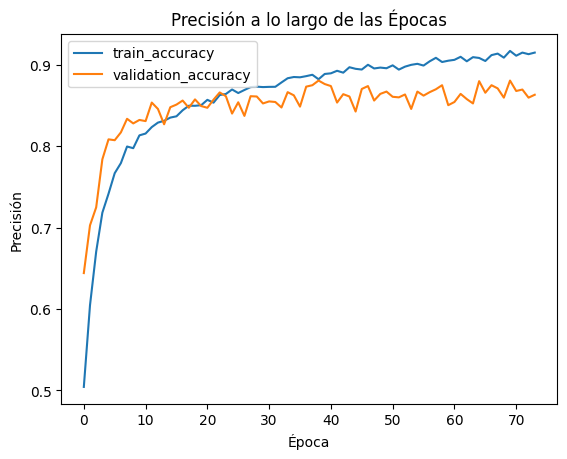

In [15]:
# modelo combinado con capas de ambos modelos que mejor rindieron
model_combined = Sequential([
    # primera capa convolucional
    Convolution2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # segunda capa convolucional
    Convolution2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # tercera capa convolucional
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # cuarta capa convolucional de uno de los modelos
    Convolution2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # capas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(len(categories), activation='softmax'), 
])

# compilar el modelo
model_combined.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_combined = model_combined.fit(
    train_generator_2,
    epochs=74, 
    validation_data=validation_generator
)

MostrarHistorial(history_combined)

En este gráfico, al aumentar el número de épocas hasta 74, observamos que la **precisión de entrenamiento** alcanza aproximadamente **0.91**, mientras que la **precisión de validación** fluctúa alrededor de **0.86**. Las fluctuaciones en la precisión de validación persisten, aunque se mantienen dentro de un rango relativamente estable. A pesar del aumento en la cantidad de épocas, la precisión de validación no muestra una mejora significativa después de las primeras 50 épocas.

La brecha entre las curvas de entrenamiento y validación, aunque pequeña, podría ser indicativa de un sobreajuste leve, especialmente considerando que la precisión de entrenamiento sigue aumentando mientras que la de validación se estabiliza.
Agregar más épocas no está proporcionando mejoras sustanciales en la precisión de validación, lo que sugiere que el modelo ha alcanzado su límite con la configuración actual.

In [25]:
optimizer = Adam(learning_rate=0.0001)

model_combined.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_combined = model_combined.fit(
    train_generator_2,
    epochs=10,  
    validation_data=validation_generator
)

MostrarHistorial(history_combined)

Epoch 1/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 236ms/step - accuracy: 0.3724 - loss: 1.5192 - val_accuracy: 0.5530 - val_loss: 1.1432
Epoch 2/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - accuracy: 0.5598 - loss: 1.1373 - val_accuracy: 0.6235 - val_loss: 0.9940
Epoch 3/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 227ms/step - accuracy: 0.6200 - loss: 1.0113 - val_accuracy: 0.6797 - val_loss: 0.8748
Epoch 4/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.6395 - loss: 0.9439 - val_accuracy: 0.6217 - val_loss: 1.0269
Epoch 5/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 211ms/step - accuracy: 0.6612 - loss: 0.8979 - val_accuracy: 0.7253 - val_loss: 0.7496
Epoch 6/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6902 - loss: 0.8405 - val_accuracy: 0.6893 - val_loss: 0.8112
Epoch 7/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.7051 - loss: 0.8126 - val_accuracy: 0.7221 - val_loss: 0.7263
Epoch 8/74
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.7148 - loss: 0

KeyboardInterrupt: 

Tras ajustar el learning rate a un valor más bajo, observamos que los resultados no mejoraron; de hecho, la precisión de validación mostró un ligero descenso y fluctuaciones más pronunciadas. Esto indica que, en este caso, reducir la tasa de aprendizaje no contribuyó a una mejor convergencia, sino que ralentizó el proceso de ajuste del modelo y posiblemente afectó su capacidad de generalización. 

Este resultado sugiere que el modelo ya estaba funcionando de manera óptima con el learning rate predeterminado, y que ajustes adicionales en otros hiperparámetros o en la arquitectura podrían ser más efectivos.

## Modelos ganadores

Nuestros mejores modelos, **`model_combined`** y **`model_the_best_10`**, comparten una arquitectura similar, compuesta por cuatro capas convolucionales con filtros crecientes (16, 128) y un tamaño de kernel uniforme de (3 ,3), seguidas por capas densas con 128 neuronas y Dropout (0.5) para regularización. Ambos utilizan **MaxPooling** después de cada capa convolucional para reducir la dimensionalidad y optimizar el aprendizaje de las características más relevantes. Estas configuraciones resultaron ser las más efectivas en términos de precisión y generalización, consolidándose como las mejores soluciones para nuestro problema de clasificación.


## Generando csv para competición

In [13]:
#Generador de CSV
test_dir = './test/'
file_names = os.listdir(test_dir)
file_paths = [os.path.join(test_dir, file_name) for file_name in file_names]

df_test = pd.DataFrame({"filename": file_names, "class": ["unknown"] * len(file_names)})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = model_combined.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

predicted_classes = [class_labels[np.argmax(pred)] for pred in predictions]

# obtenemos los nombres de las imágenes
image_filenames = [img_path.split('/')[-1] for img_path in test_generator.filepaths]

# creamos el DataFrame con las predicciones en el formato solicitado
results_df = pd.DataFrame({
    'ID': image_filenames,
    'Label': predicted_classes
})

# guardamos las predicciones en un archivo CSV
results_df.to_csv('predictions.csv', index=False)
print("Predicciones guardadas en 'predictions.csv'")

Found 3000 validated image filenames.
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
Predicciones guardadas en 'predictions.csv'


## Un poco de la etapa de experimentación

Modelos al azar

## Pruebas Rápidas de Modelos y Combinaciones de Parámetros

Durante el proceso de experimentación, realizamos pruebas rápidas con diferentes configuraciones de modelos para explorar posibles patrones o combinaciones de hiperparámetros que pudieran mejorar el rendimiento. Esta etapa nos permitió evaluar múltiples variantes de forma ágil, eliminando aquellas que mostraban un desempeño inferior y conservando los modelos con mejores resultados.

Aunque este enfoque no garantizó una mejora significativa, nos permitió generar variantes de modelos con combinaciones únicas de capas y parámetros. Esto ayudó a diversificar las pruebas y a identificar configuraciones potencialmente prometedoras para un análisis más detallado. 

En resumen, esta estrategia nos sirvió como una herramienta exploratoria, pero su impacto directo en la optimización global del modelo aún es incierto.

In [9]:
# lista para almacenar modelos y configuraciones de hiperparámetros
model_combinations = []

# combinación 3: 
model3 = Sequential([
    Convolution2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    Convolution2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('Overfit Prone Model 3', model3))


# combinación 4: uso de tanh en lugar de ReLU, con dropout moderado
model4 = Sequential([
    Convolution2D(8, (3, 3), activation='tanh', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(20, activation='tanh'),
    Dropout(0.25),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('Tanh Activation Model 4', model4))

# combinación 5: mas capas densas con baja cantidad de unidades, dropout alto
model5 = Sequential([
    Convolution2D(8, (4, 4), activation='relu', input_shape=(150, 150, 3)),
    Convolution2D(8, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('High Dropout Model 5', model5))

# combinación 7: modelo con más capas convolucionales y dropout alto
model7 = Sequential([
    Convolution2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Convolution2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Convolution2D(64, (3, 3), activation='relu'),
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('Deep Dropout Model 7', model7))

# combinación 8: cambiando tamaño de kernel y usando dropout bajo
model8 = Sequential([
    Convolution2D(16, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    Convolution2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('Large Kernel Low Dropout Model 8', model8))

# combinación 10: modelo con más capas densas y bajo dropout
model10 = Sequential([
    Convolution2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Convolution2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')
])
model_combinations.append(('Dense Layers Low Dropout Model 10', model10))


In [10]:
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)


In [13]:
for name, model in model_combinations:
    print(f"Entrenando: {name}")
    history = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"{name} - Precisión de validación final: {val_accuracy:.4f}")


Entrenando: Simple Model 1
Epoch 1/5


C:\Users\NicoEvi\Documents\Universidad\machine-learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.4569 - loss: 1.4516 - val_accuracy: 0.6210 - val_loss: 0.9991
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6868 - loss: 0.8476 - val_accuracy: 0.6363 - val_loss: 1.0004
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7741 - loss: 0.6454 - val_accuracy: 0.6431 - val_loss: 0.9710
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.8393 - loss: 0.4890 - val_accuracy: 0.6381 - val_loss: 1.0263
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8833 - loss: 0.3800 - val_accuracy: 0.6313 - val_loss: 1.0643
Simple Model 1 - Precisión de validación final: 0.6313
Entrenando: No Dropout Model 2
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 157ms/step - accuracy: 0.3764 - loss: 1.8133 - val_accuracy: 0.6737 - val_loss: 0.8891
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.7231 - loss: 0.7489 - val_accuracy: 0.7359 - val_loss: 0.7693
Epoch 3/5
351/351 ━

## Muestras de como predice nuestro mejor modelo

Este código selecciona **20 imágenes aleatorias** y las utiliza para realizar predicciones con el modelo entrenado. Este enfoque permite evaluar rápidamente el rendimiento del modelo en nuevas imágenes de prueba de manera aleatoria.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


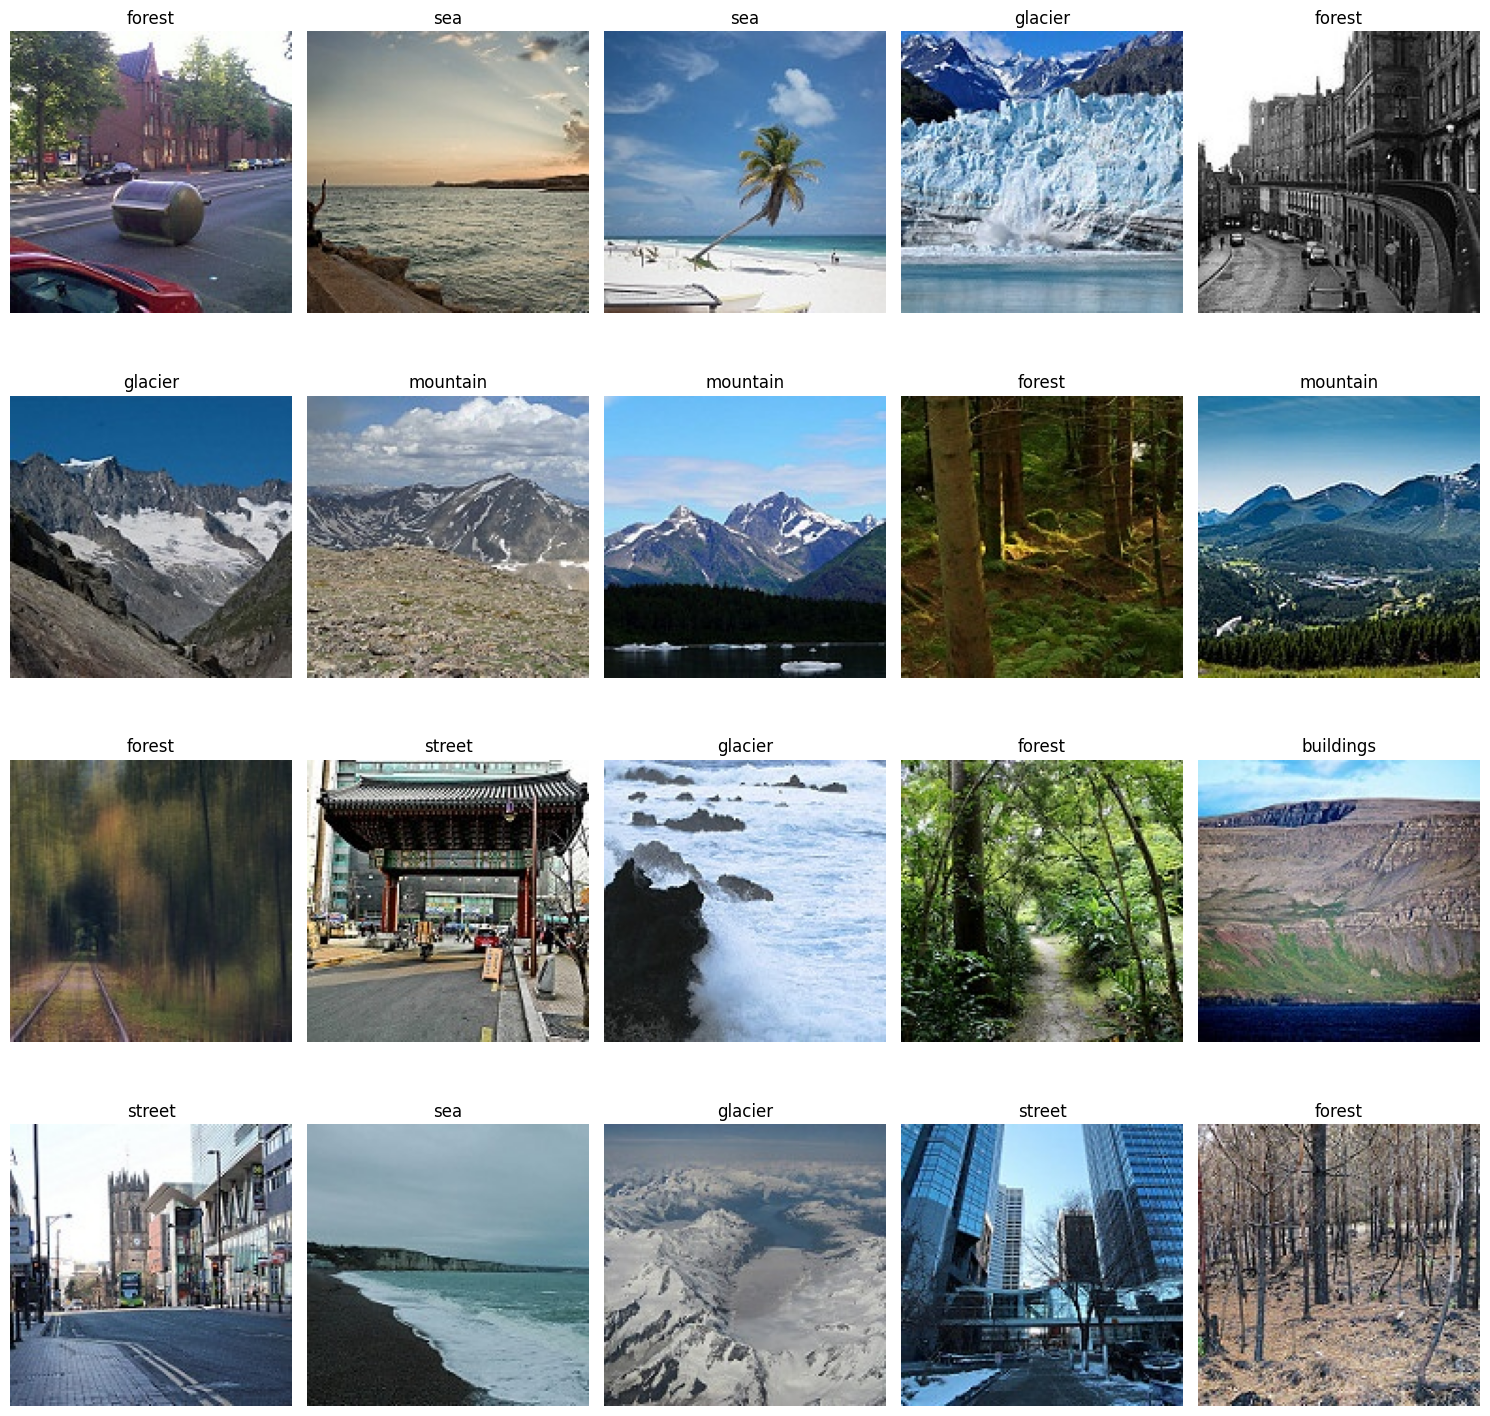

In [28]:
img_size = (150, 150)

test_images_dir = "./test/"

all_test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.png'))]

# seleccionar 20 imágenes al azar
random_images_paths = random.sample(all_test_images, 20)

test_images = []
for img_path in random_images_paths:
    img = load_img(img_path, target_size=img_size) 
    img_array = img_to_array(img)  
    img_array = img_array / 255.0 
    test_images.append(img_array)

test_images = np.array(test_images)

predictions = model_conv_1.predict(test_images)

# decodificar las predicciones
class_labels = list(train_generator.class_indices.keys()) 
predicted_classes = [class_labels[np.argmax(pred)] for pred in predictions]

# mostrar las imágenes y sus predicciones
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(predicted_classes[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

El modelo realiza buenas predicciones cuando las características visuales son claras y distintivas, pero tiende a confundirse en escenarios donde hay solapamiento visual, como ciudades con árboles que se clasifican erróneamente como forest, edificios altos cercanos que se confunden con mountain o forest, o incluso glacier y mountain, que son difíciles de distinguir incluso para nosotros.

## Conclusiones

El desarrollo y ajuste de modelos de redes neuronales, como los MLP y CNN, requiere un enfoque iterativo que puede resultar desafiante. Durante los entrenamientos realizados, notamos un uso intensivo de recursos, con picos de consumo de CPU que alcanzaron el 100%. Esto refleja la alta demanda computacional que estos modelos imponen, incluso en configuraciones relativamente sencillas.

Además, el proceso de ajuste de hiperparámetros se asemeja a una "caja negra", donde probar combinaciones al azar puede parecer un ejercicio sin dirección clara. Aunque existen guías y prácticas recomendadas, el impacto de cada ajuste no siempre es evidente hasta que se entrena el modelo. Por ello, en este proyecto recurrimos también a configuraciones compartidas por otros usuarios en plataformas especializadas, adaptándolas a nuestras necesidades.

Un desafío adicional fue mantener un **orden adecuado en la documentación de las pruebas**, ya que se realizaron numerosas experimentaciones. En varios casos, los resultados de pruebas anteriores fueron sobreescritos o eliminados al probar nuevas combinaciones, lo que dificultó el seguimiento completo del proceso. Observamos, además, que repetir secuencialmente el mismo modelo ofrecía resultados más consistentes, pero esto complicó la consolidación de modelos diversos en el documento.

Con respecto a la **competencia**, creemos que este proceso representa un desafío interesante, ya que motiva a buscar continuamente los mejores resultados. Sin embargo, la **falta de una GPU** y las limitaciones técnicas de la CPU influyeron en el tiempo requerido para entrenar los modelos. Esto resultó en largos períodos de espera, lo que ralentizó el ciclo de pruebas y afectó la eficiencia general.

Cabe destacar que este tipo de trabajo requiere una documentación exhaustiva de todas las pruebas realizadas y sus resultados. Sin una gestión adecuada de las variantes probadas, existe el riesgo de que ciertos experimentos queden obsoletos o deprecados, lo que podría dificultar la replicación o mejora de los modelos en el futuro.

A pesar de estos desafíos, los resultados mejoraron progresivamente, lo que refuerza la importancia de un enfoque sistemático y bien documentado para optimizar tanto la arquitectura como los hiperparámetros de los modelos.
